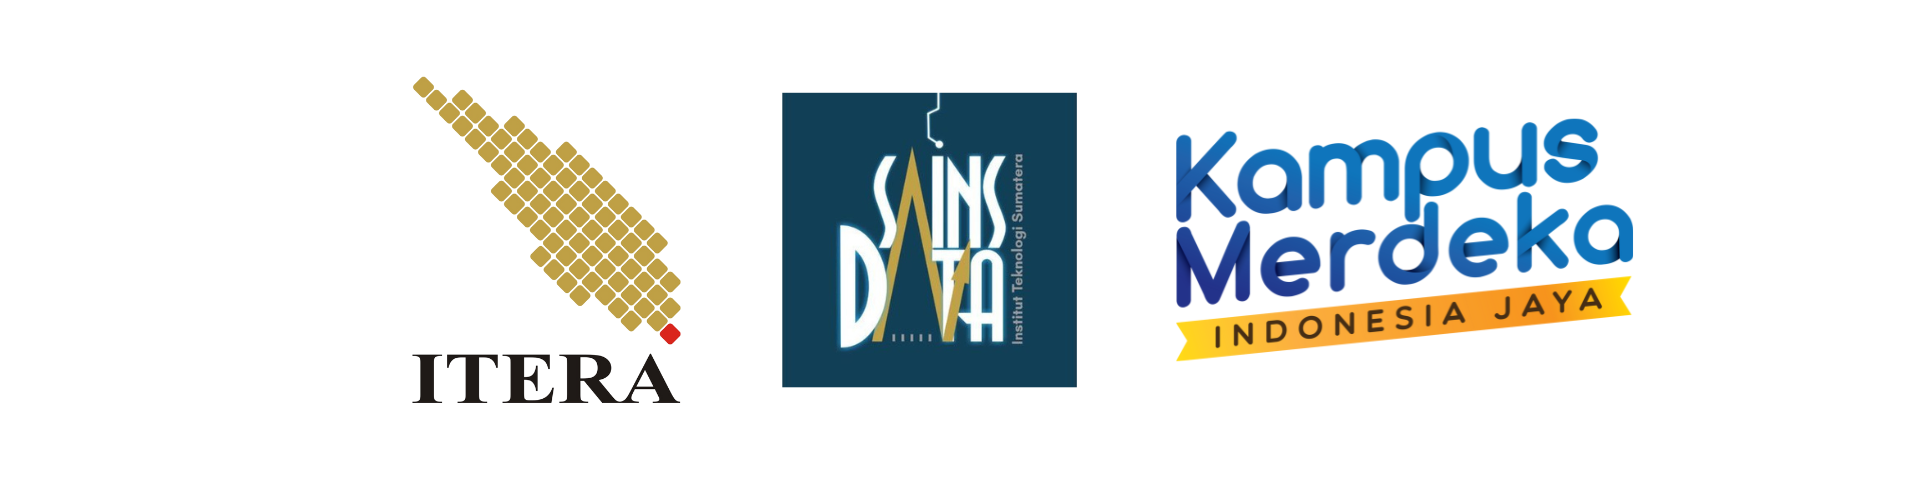

## **Big Task - Group 06**

### **Task Topic**
_Sentiment Analysis Using GRU_

### **Members Of The Group**
| Student Name | Student ID | Class |
| --- | --- | --- |
| Kevin Simorangkir | 121140150 | RA |
| Husni Na'fa Mubarok | 121450078 | RA |
| Dwi Sulistiani | 121450079 | RB |
| Ramadhita Atifa Hendri | 121450131 | RC |
| Mayada | 121450145| RC |

### **Name Of Supervisor**
Rohmi Dyah Astuti, S.Si., M.Cs

---

### **Menginstall _!nvidia-smi_**

In [ ]:
!nvdia-smi

- Fungsi dari `!nvdia-smi` adalah untuk menampilkan informasi GPU yang digunakan.

### **Menginstall _!pip install contractions_**

In [1]:
pip install contractions

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


- Fungsi `pip install contractions` adalah untuk menginstall library contractions yang digunakan untuk memperpendek kata-kata dalam kalimat.

### **Menginstall Library**
Pada tahap pertama ini menginstall library yang akan digunakan dalam proses analisis sentimen menggunakan GRU.

In [2]:
from sklearn.metrics import precision_recall_curve, f1_score, auc
from keras.layers import Input, Embedding, Bidirectional, Concatenate, Dense, Dropout, LSTM  # , CuDNNGRU
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import backend as K
from keras.layers import Layer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from nltk.tokenize import word_tokenize
import contractions
import unicodedata
import tqdm
import nltk
import re
import time
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Fungsi dari library tersebut adalah sebagai berikut:
1. `pandas` : digunakan untuk memanipulasi data.
2. `numpy` : digunakan untuk operasi matematika.
3. `matplotlib` : digunakan untuk visualisasi data.
4. `seaborn` : digunakan untuk visualisasi data.
5. `nltk` : digunakan untuk memproses teks.
6. `contractions` : digunakan untuk memperpendek kata-kata dalam kalimat.
7. `re` : digunakan untuk operasi regular expression.
8. `tensorflow` : digunakan untuk membangun model GRU.
9. `keras` : digunakan untuk membangun model GRU.
10. `sklearn` : digunakan untuk membagi data menjadi data training dan data testing.
11. `collections` : digunakan untuk menghitung jumlah kata dalam kalimat.
12. `wordcloud` : digunakan untuk membuat wordcloud.

### **Mengimport Data**
Dalam tahap ini mengimport data yang akan digunakan dalam proses analisis sentimen menggunakan. Datanya yaitu `DB Review Film.csv`.

In [3]:
df = pd.read_csv('Dataset/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


- Penjelasan mengenai kode di atas ini:

    1. `data` : variabel yang digunakan untuk menyimpan data yang diimport.

    2. `data.head()` : menampilkan 5 data teratas.

    3. `data.info()` : menampilkan informasi data.
        
    4. `data.describe()` : menampilkan deskripsi data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


- Fungsi `df.info()` adalah untuk menampilkan informasi data.

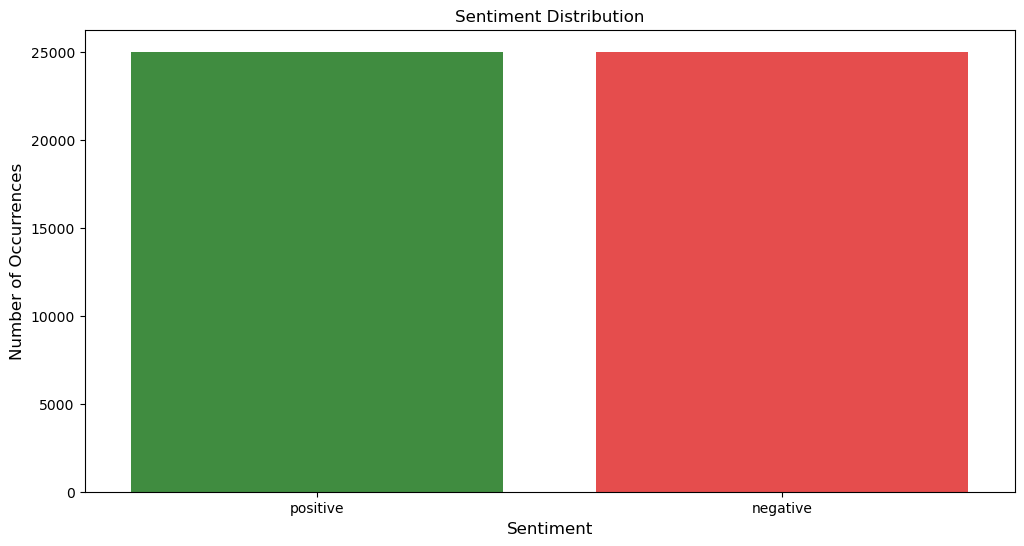

In [9]:
sentiment = df['sentiment'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=sentiment.index, y=sentiment.values, alpha=0.8, palette={'positive': 'green', 'negative': 'red'})
plt.title('Sentiment Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.savefig('Images/Sentiment_Distribution_GRU.png')
plt.show()

- Fungsi diatas yaitu sebagai berikut:
    1. Sentiment : Menunjukkan sentimen dari review
    2. Review : Menunjukkan review dari film
    3. Label : Menunjukkan label dari sentimen review

### **Pembersihan Data**
Dalam tahap ini dilakukan pembersihan data yang akan digunakan dalam proses analisis sentimen menggunakan GRU.

In [6]:
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text


def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode(
      'ascii', 'ignore').decode('utf-8', 'ignore')
  return text


def stopwords_removal(words):
    list_stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in words if word not in list_stopwords]

In [7]:
def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    # case folding
    doc = doc.lower()
    # remove special characters\whitespaces
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I | re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    # tokenize
    doc = word_tokenize(doc)
    # filtering
    doc = stopwords_removal(doc)
    norm_docs.append(doc)

  norm_docs = [" ".join(word) for word in norm_docs]
  return norm_docs

In [8]:
# Measure the start time
start_time = time.time()

# Download the stopwords
nltk.download('stopwords')

# Process the reviews
df['review'] = pre_process_corpus(df.review)

# Measure the end time
end_time = time.time()

# Print the execution time
print(f"Execution time: {end_time - start_time} seconds")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 50000/50000 [01:59<00:00, 419.72it/s]


Execution time: 121.17516541481018 seconds


In [10]:
df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter matteis love time money visually stunni...,positive


### **Memisahkan Data**
Dalam tahap ini dilakukan pemisahan data menjadi data training dan data testing.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df.review, df.sentiment, test_size=0.1, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (45000,)
X_test shape: (5000,)
y_train shape: (45000,)
y_test shape: (5000,)


### **Tokenizer**
Tokenizer digunakan untuk mengubah kata-kata dalam kalimat menjadi angka. Dalam tahap ini dilakukan tokenisasi pada data training dan data testing.

In [12]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(X_test)
t.word_index['<PAD>'] = 0

### **Sequence**
Sequence digunakan untuk membuat panjang kalimat menjadi sama. Dalam tahap ini dilakukan sequence pada data training dan data testing.

In [13]:
train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)
VOCAB_SIZE = len(t.word_index)

print("Vocabulary size : {}".format(len(t.word_index)))
print("Number of Documents : {}".format(t.document_count))

Vocabulary size : 55190
Number of Documents : 5000


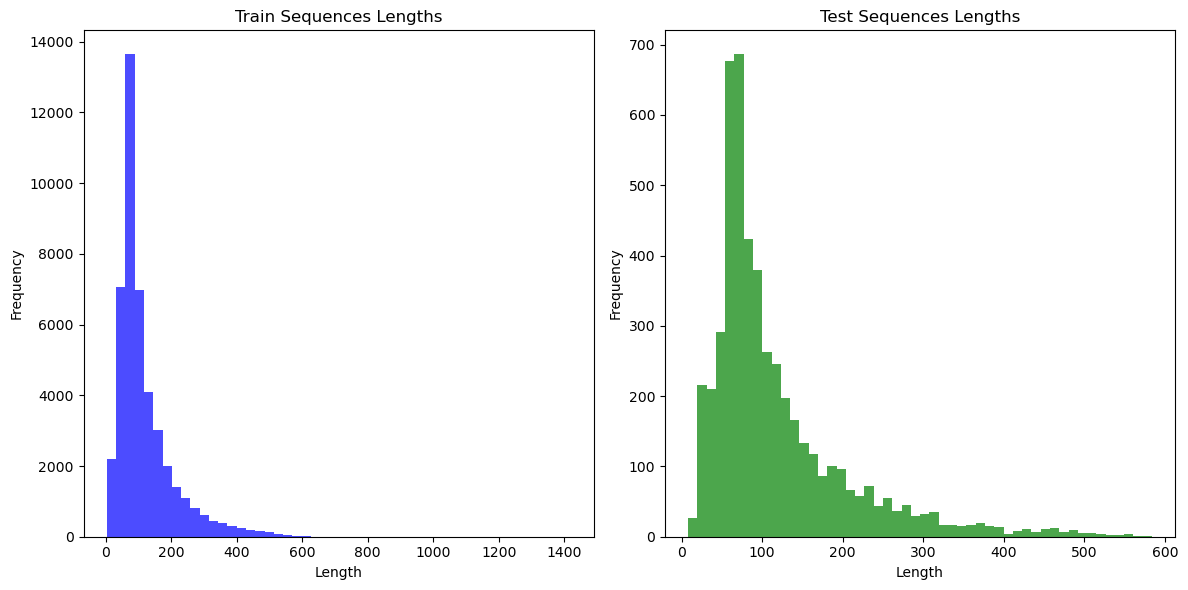

In [14]:
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(train_lens, bins=50, color='blue', alpha=0.7)
ax[0].set_title('Train Sequences Lengths')
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Frequency')

ax[1].hist(test_lens, bins=50, color='green', alpha=0.7)
ax[1].set_title('Test Sequences Lengths')
ax[1].set_xlabel('Length')
ax[1].set_ylabel('Frequency')

plt.savefig('Images/Train & Sequences Lengths.png')
plt.tight_layout()
plt.show()

### **Sequence Normalization**
Sequence normalization digunakan untuk membuat panjang kalimat menjadi sama. Dalam tahap ini dilakukan sequence normalization pada data training dan data testing.

In [15]:
MAX_SEQUENCE_LENGTH = 100

# pad dataset to a maximum review length in words
X_train = tf.keras.utils.pad_sequences(
    train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.utils.pad_sequences(
    test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (45000, 100)
X_test shape: (5000, 100)
y_train shape: (45000,)
y_test shape: (5000,)


### **Encoding Labels**
Encoding labels digunakan untuk mengubah label menjadi angka. Dalam tahap ini dilakukan encoding labels pada data training dan data testing.

In [16]:
le = LabelEncoder()
num_classes = 2

In [17]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print("Classes:", le.classes_)
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("y_train sample: {}".format(y_train[0:5]))
print("y_test sample: {}".format(y_test[0:5]))

Classes: ['negative' 'positive']
y_train shape: (45000,)
y_test shape: (5000,)
y_train sample: [1 1 0 1 1]
y_test sample: [1 1 0 1 0]


### **Modelling Bidirectional GRU**
Modeling bidirectional GRU digunakan untuk membangun model GRU. Dalam tahap ini dilakukan modeling bidirectional GRU.

In [18]:
EMBEDDING_DIM = 300  # dimension for dense embeddings for each token
GRU_DIM = 32  # total GRU units

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = Embedding(
    VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(sequence_input)
# bigru = Bidirectional(layers.CuDNNGRU(GRU_DIM, return_sequences=True))(embedded_sequences)
bigru = keras.layers.Bidirectional(keras.layers.GRU(
    GRU_DIM, return_sequences=False, recurrent_dropout=0.2))(embedded_sequences)
# att = AttentionLayer(MAX_SEQUENCE_LENGTH)(bigru)
dense1 = Dense(GRU_DIM*2, activation='relu')(bigru)
dropout1 = Dropout(rate=0.3)(dense1)
dense2 = Dense(GRU_DIM, activation='relu')(dropout1)
dropout2 = Dropout(rate=0.3)(dense2)

outp = keras.layers.Dense(1, activation='sigmoid')(dense2)
# initialize the model
model_bigru = keras.models.Model(inputs=sequence_input, outputs=outp)


model_bigru.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(
    learning_rate=0.001), metrics=['accuracy'])
model_bigru.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 300)       │    16,557,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,627,401 (63.43 MB)

 Trainable params: 16,627,401 (63.43 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
pip install pydot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


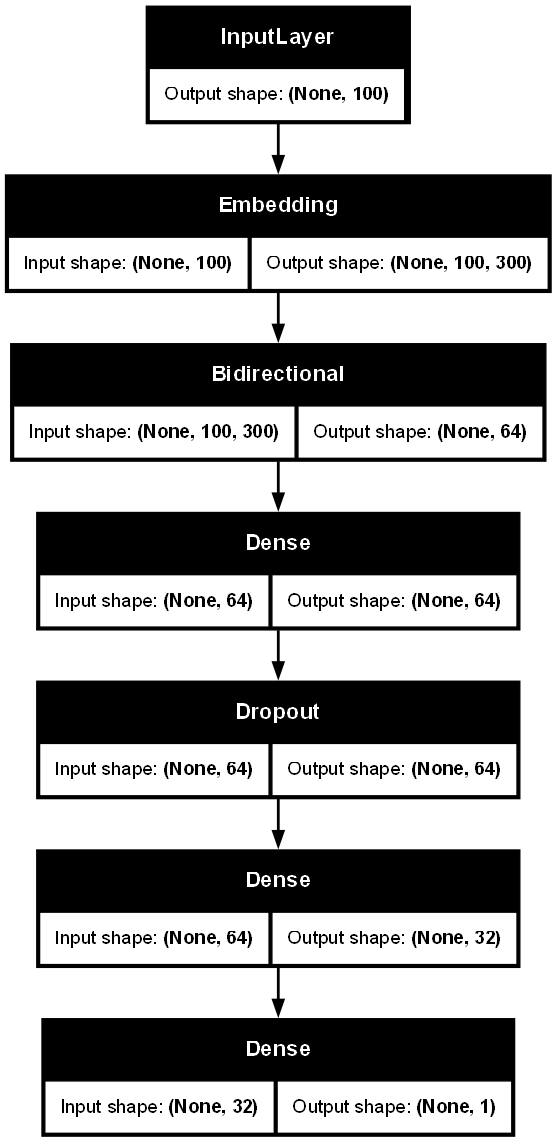

In [ ]:
keras.utils.plot_model(model_bigru, show_shapes=True, dpi=100)

### **Train Model**
Train Model digunakan untuk melatih model GRU. Dalam tahap ini dilakukan train model.

In [23]:
epochs = 10
batch_size = 128

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('./best_model/best_model_bigru.keras',
                     monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history = model_bigru.fit(X_train, y_train,  batch_size=batch_size, shuffle=True,
                          validation_split=0.1, epochs=epochs, verbose=1, callbacks=[es, mc])

Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6783 - loss: 160.7418
Epoch 1: val_loss improved from inf to 0.50350, saving model to ./best_model/best_model_bigru.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 159s 481ms/step - accuracy: 0.6785 - loss: 160.6064 - val_accuracy: 0.7500 - val_loss: 0.5035
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.8635 - loss: 0.3327
Epoch 2: val_loss did not improve from 0.50350
317/317 ━━━━━━━━━━━━━━━━━━━━ 149s 470ms/step - accuracy: 0.8635 - loss: 0.3327 - val_accuracy: 0.7564 - val_loss: 0.5055
Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9154 - loss: 2.2865
Epoch 3: val_loss did not improve from 0.50350
317/317 ━━━━━━━━━━━━━━━━━━━━ 147s 462ms/step - accuracy: 0.9154 - loss: 2.2830 - val_accuracy: 0.7416 - val_loss: 0.5655
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9458 - loss: 0.1538
Epoch 4: val_loss did not improve from 0.50350
317/317 ━━━━━━━━━━━━━━━━━━━━ 146s 460ms/

### **Evaluation**
#### **Model Accuracy**
`Model Accuracy` digunakan untuk mengetahui akurasi model GRU. Dalam tahap ini dilakukan evaluasi model accuracy.

In [24]:
saved_model = load_model('./best_model/best_model_bigru.keras')
train_acc = saved_model.evaluate(X_train, y_train, verbose=1)
test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.8351 - loss: 0.4043
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7555 - loss: 0.4924
Train: 82.80%, Test: 75.68%


#### **Identify Overfitting**
`Identify Overfitting` adalah sebuah tahap yang mana digunakan untuk mengetahui apakah model yang dibuat mengalami overfitting atau tidak.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


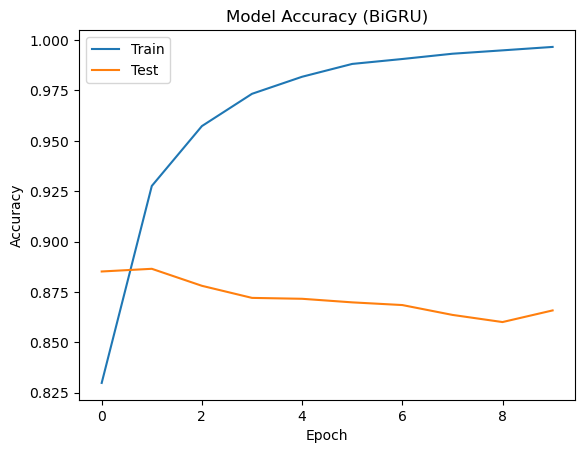

In [50]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (BiGRU)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Images/Model Accuracy (BiGRU).png')
plt.show()

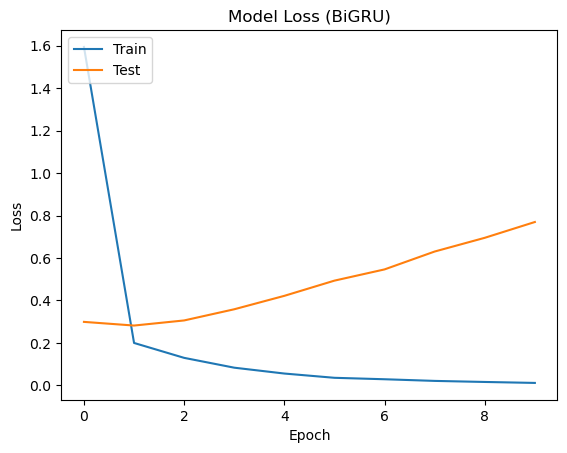

In [49]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss (BiGRU)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Images/Model Loss (BiGRU).png')
plt.show()

In [28]:
predictionProbs = model_bigru.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictionProbs]

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step


#### **Confusion Matrix**
`Confusion Matrix` adalah sebuah tahap yang mana digunakan untuk mengetahui hasil prediksi model GRU. Dalam tahap ini dilakukan evaluasi confusion matrix.

In [29]:
labels = ['positive', 'negative']
print(classification_report(y_test, predictions, target_names=labels))
pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    positive       0.69      0.77      0.73      2481
    negative       0.75      0.66      0.70      2519

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



,positive,negative
positive,1921,560
negative,844,1675


#### **ROC AUC**
`ROC AUC` adalah sebuah tahap yang mana digunakan untuk mengetahui seberapa baik model dalam memprediksi data. Dalam tahap ini dilakukan evaluasi ROC AUC.

In [47]:
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (BiGRU)')
    plt.legend(loc="lower right")
    plt.show()

Model ROC-AUC score: 0.793


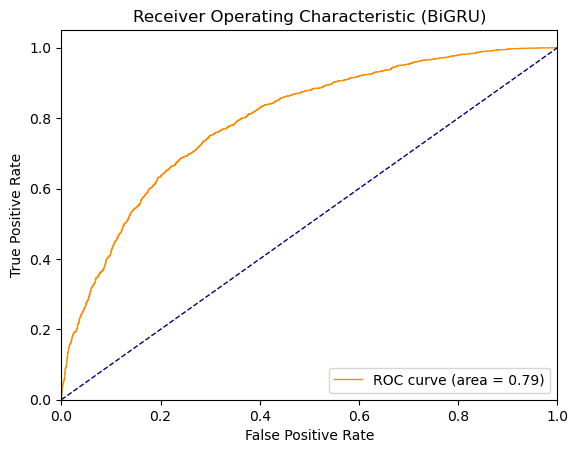

<Figure size 640x480 with 0 Axes>

In [48]:
print('Model ROC-AUC score: %.3f' % roc_auc_score(y_test, predictionProbs))

plot_roc_curve(y_test, predictionProbs)
roc_auc = roc_auc_score(y_test, predictionProbs)
plt.savefig('Images/Receiver Operating Characteristic (BiGRU).png')

#### **Precision Recall**
`Precision Recall` adalah sebuah tahap yang mana digunakan untuk mengetahui seberapa baik model dalam memprediksi data. Dalam tahap ini dilakukan evaluasi precision recall.

Model PR-AUC score: 0.781


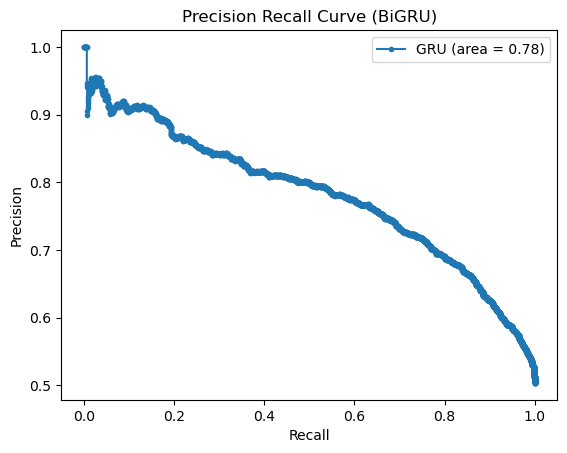

In [44]:
precision, recall, thresholds = precision_recall_curve(y_test, predictionProbs)
print('Model PR-AUC score: %.3f' % auc(recall, precision))
plt.plot(recall, precision, marker='.', label='GRU (area = %0.2f)' % auc(recall, precision))
plt.title('Precision Recall Curve (BiGRU)')
plt.figsize=(12, 6)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('Images/Precision Recall Curve (BiGRU).png')
plt.legend()
plt.show()

### **Modelling GRU Attention Bidirectional**
`Modelling GRU Attention Bidirectional` digunakan untuk membangun model GRU Attention Bidirectional. Dalam tahap ini dilakukan modeling GRU Attention Bidirectional. 

#### **Attention Mechanism**
`Attention Mechanism` adalah sebuah mekanisme yang digunakan untuk memberikan bobot pada setiap kata dalam kalimat. Dalam tahap ini dilakukan attention mechanism.

In [37]:
from tensorflow import keras


class AttentionLayer(keras.layers.Layer):
  def __init__(self, step_dim,
               W_regularizer=None, b_regularizer=None,
               W_constraint=None, b_constraint=None,
               bias=True, **kwargs):
    super(AttentionLayer, self).__init__(**kwargs)
    self.supports_masking = True
    self.init = keras.initializers.get('glorot_uniform')
    self.W_regularizer = keras.regularizers.get(W_regularizer)
    self.b_regularizer = keras.regularizers.get(b_regularizer)
    self.W_constraint = keras.constraints.get(W_constraint)
    self.b_constraint = keras.constraints.get(b_constraint)
    self.bias = bias
    self.step_dim = step_dim
    self.features_dim = 0

  def build(self, input_shape):
    assert len(input_shape) == 3
    self.W = self.add_weight(shape=(input_shape[-1],),
                             initializer=self.init,
                             name='{}_W'.format(self.name),
                             regularizer=self.W_regularizer,
                             constraint=self.W_constraint)
    self.features_dim = input_shape[-1]
    if self.bias:
      self.b = self.add_weight(shape=(input_shape[1],),
                               initializer='zero',
                               name='{}_b'.format(self.name),
                               regularizer=self.b_regularizer,
                               constraint=self.b_constraint)
    else:
      self.b = None
    self.built = True

  def compute_mask(self, input, input_mask=None):
    return None  # Do not pass the mask to the next layers

  def call(self, x, mask=None):
    features_dim = self.features_dim
    step_dim = self.step_dim

    eij = keras.backend.dot(keras.backend.reshape(x, (-1, features_dim)),
                            keras.backend.reshape(self.W, (features_dim, 1)))
    eij = keras.backend.reshape(eij, (-1, step_dim))

    if self.bias:
      eij += self.b

    eij = keras.activations.tanh(eij)
    a = keras.backend.exp(eij)

    if mask is not None:
      a *= mask  # No need for casting to floatX in TensorFlow 2.x

    # Consider removing epsilon if necessary
    a /= keras.backend.sum(a, axis=1, keepdims=True) + keras.backend.epsilon()
    a = keras.backend.expand_dims(a)
    weighted_input = x * a

    return keras.backend.sum(weighted_input, axis=1)

  def compute_output_shape(self, input_shape):
    return input_shape[0], self.features_dim

  def get_config(self):
      config = {'step_dim': self.step_dim}
      base_config = super(AttentionLayer, self).get_config()
      return dict(list(base_config.items()) + list(config.items()))

#### **Model Architecture**
`Model Architecture` adalah sebuah tahap yang mana digunakan untuk mengetahui arsitektur model GRU Attention Bidirectional. Dalam tahap ini dilakukan evaluasi model architecture.

In [38]:
EMBEDDING_DIM = 300  # dimension for dense embeddings for each token
GRU_DIM = 32  # total GRU units

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = Embedding(
    VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(sequence_input)
bigru = keras.layers.Bidirectional(keras.layers.GRU(
    GRU_DIM, return_sequences=True, recurrent_dropout=0.2))(embedded_sequences)
att = AttentionLayer(MAX_SEQUENCE_LENGTH)(bigru)

dense1 = Dense(GRU_DIM*2, activation='relu')(att)
dropout1 = Dropout(rate=0.3)(dense1)
dense2 = Dense(GRU_DIM, activation='relu')(dropout1)
dropout2 = Dropout(rate=0.3)(dense2)

outp = keras.layers.Dense(1, activation='sigmoid')(dropout2)
model_bigru_att = keras.models.Model(inputs=sequence_input, outputs=outp)
model_bigru_att.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(
    learning_rate=0.001), metrics=['accuracy'])
model_bigru_att.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 300)       │    16,557,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 64)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 64)             │           164 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,627,565 (63.43 MB)

 Trainable params: 16,627,565 (63.43 MB)

 Non-trainable params: 0 (0.00 B)

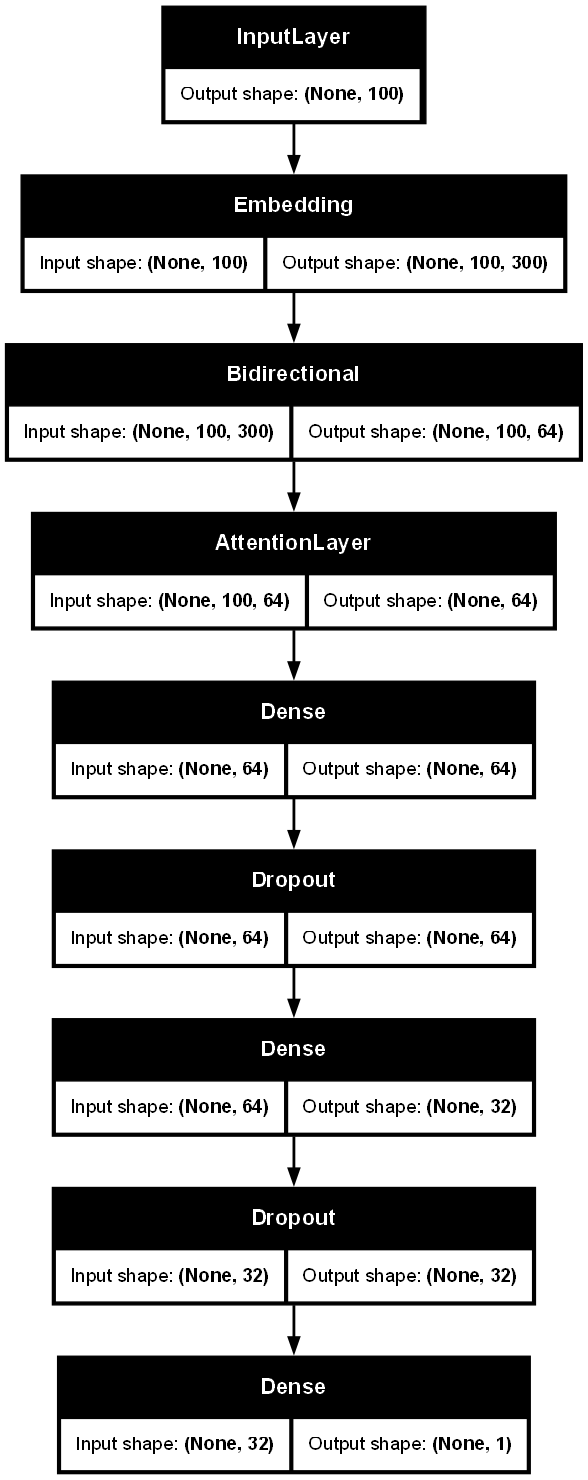

In [39]:
keras.utils.plot_model(model_bigru_att, show_shapes=True, dpi=100)

#### **Train Model**
`Train Model` digunakan untuk melatih model GRU Attention Bidirectional. Dalam tahap ini dilakukan train model.

In [40]:
epochs = 10
batch_size = 128

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('./best_model/best_model_bigru_att.keras',
                     monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history = model_bigru_att.fit(X_train, y_train,  batch_size=batch_size, shuffle=True,
                              validation_split=0.1, epochs=epochs, verbose=1, callbacks=[es, mc])

Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7510 - loss: 2.6853
Epoch 1: val_loss improved from inf to 0.29873, saving model to ./best_model/best_model_bigru_att.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 211s 622ms/step - accuracy: 0.7512 - loss: 2.6818 - val_accuracy: 0.8851 - val_loss: 0.2987
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9279 - loss: 0.2012
Epoch 2: val_loss improved from 0.29873 to 0.28145, saving model to ./best_model/best_model_bigru_att.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 154s 487ms/step - accuracy: 0.9279 - loss: 0.2012 - val_accuracy: 0.8864 - val_loss: 0.2814
Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9619 - loss: 0.1213
Epoch 3: val_loss did not improve from 0.28145
317/317 ━━━━━━━━━━━━━━━━━━━━ 153s 482ms/step - accuracy: 0.9619 - loss: 0.1213 - val_accuracy: 0.8780 - val_loss: 0.3055
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9781 - loss: 0.0749
Epoch 4: val_loss did not 

### **Evaluation**
#### **Model Accuracy**
`Model Accuracy` digunakan untuk mengetahui akurasi model GRU. Dalam tahap ini dilakukan evaluasi model accuracy.

In [41]:
saved_model = load_model('./best_model/best_model_bigru_att.keras',
                         custom_objects={'AttentionLayer': AttentionLayer})
train_acc = saved_model.evaluate(X_train, y_train, verbose=1)
test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.9668 - loss: 0.1347
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8925 - loss: 0.2610
Train: 95.86%, Test: 88.76%


#### **Identify Overfitting**
`Identify Overfitting` adalah sebuah tahap yang mana digunakan untuk mengetahui apakah model yang dibuat mengalami overfitting atau tidak.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


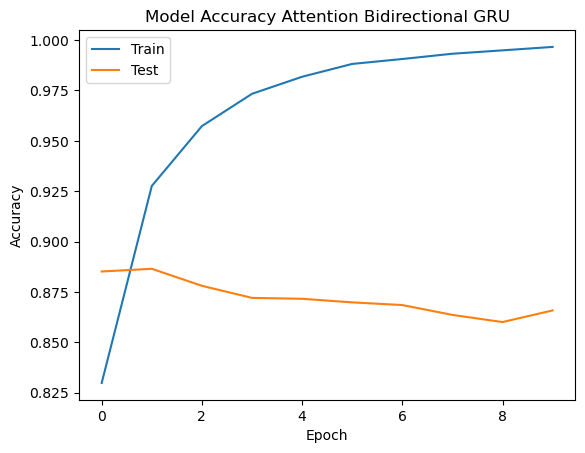

In [43]:
print(history.history.keys())  # Check the available metrics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Attention Bidirectional GRU')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Images/Model Accuracy Attention Bidirectional GRU.png')
plt.show()

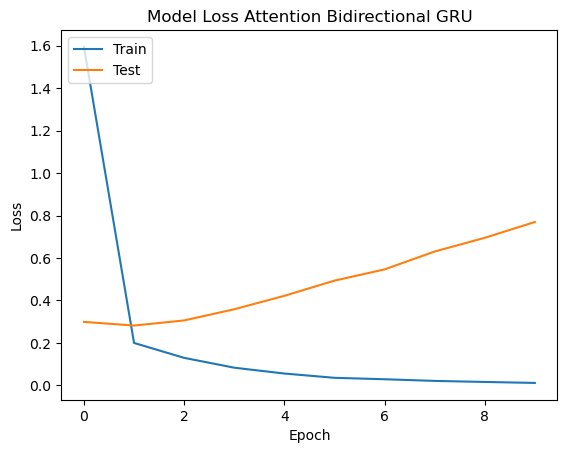

In [51]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss Attention Bidirectional GRU')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Images/Model Loss Attention Bidirectional GRU.png')
plt.show()

In [52]:
predictionProbs = model_bigru_att.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictionProbs]   

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


#### **Confusion Matrix**
`Confusion Matrix` adalah sebuah tahap yang mana digunakan untuk mengetahui hasil prediksi model GRU. Dalam tahap ini dilakukan evaluasi confusion matrix.

In [53]:
labels = ['positive', 'negative']
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions),
             index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2481
           1       0.86      0.87      0.87      2519

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



,positive,negative
positive,2117,364
negative,317,2202


#### **ROC AUC**
`ROC AUC` adalah sebuah tahap yang mana digunakan untuk mengetahui seberapa baik model dalam memprediksi data. Dalam tahap ini dilakukan evaluasi ROC AUC.

In [59]:
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], ls="--")
    plt.title('ROC Curve Attention Bidirectional GRU')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig('Images/ROC Curve Attention Bidirectional GRU.png')

model AUC score: 0.9361745534422068


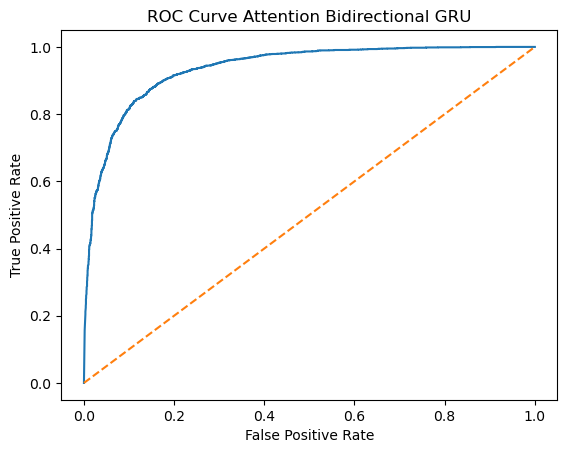

In [60]:
plot_roc_curve(y_test, predictionProbs)
print(f'model AUC score: {roc_auc_score(y_test, predictionProbs)}')

#### **Precision Recall**
`Precision Recall` adalah sebuah tahap yang mana digunakan untuk mengetahui seberapa baik model dalam memprediksi data. Dalam tahap ini dilakukan evaluasi precision recall.

model f1 score: 0.8660766961651918 model AUC score: 0.9338271131455627


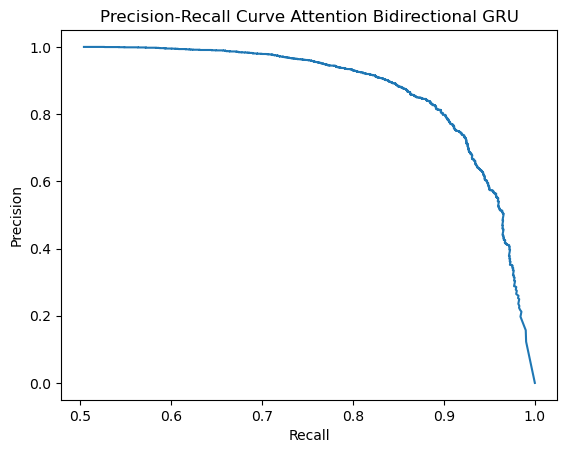

In [61]:
precision, recall, thresholds = precision_recall_curve(
    y_test, predictionProbs)
print(
    f'model f1 score: {f1_score(y_test, predictions)} model AUC score: {auc(recall, precision)}')
plt.plot(precision, recall)
plt.title('Precision-Recall Curve Attention Bidirectional GRU')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('Images/Precision-Recall Curve Attention Bidirectional GRU.png')